# 참여와 승리 횟수가 있음.

# 집단간 차이가 잘 드러나도록 변수를 만드는 것이 핵심

# 어떻게 할까?

In [1]:
#### import modules
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from pprint import pprint
from scipy.stats import kstest
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from sklearn.preprocessing import QuantileTransformer

In [2]:
#### training data set
train_activity= pd.read_csv('../transformed/real_values_int.csv')

#### load activity dataset
train_label = pd.read_csv('../lite_data/train_label_lite.csv')

In [5]:
cols = train_activity.columns
train_activity = train_activity.loc[:,[cols[-1],cols[-2]] + cols[0:-2].tolist()].copy()

In [3]:
def new_variable_checker(total, var):
    
    col_name = var.name
#     #### 표준화
#     var = (var - var.mean())/var.std()
    
    df = total.loc[:,('label',col_name)]
    #### rank transformation
    q_t = QuantileTransformer()
    df[col_name] = pd.Series(q_t.fit_transform(df[col_name].values.reshape(-1, 1)).reshape(-1),name = col_name)
    
    #### 검정을 위한 표 만들기

    table = df.pivot(columns='label',values = col_name)
    table = pd.concat((table['retained'].dropna().reset_index(drop = True),
               table['2month'].dropna().reset_index(drop = True),
               table['month'].dropna().reset_index(drop = True),
               table['week'].dropna().reset_index(drop = True)),axis = 1)
    
    #### 정규성 검정
    _, n_0 = kstest(table['retained'],'norm')
    _, n_1 = kstest(table['2month'],'norm')
    _, n_2 = kstest(table['month'],'norm')
    _, n_3 = kstest(table['week'],'norm')
    
    #### box plot
    table.plot.box()
    
    ##### 네 집단 사이의 평균검정.
    
    if (n_0 <0.05) and (n_1 <0.05) and (n_2 <0.05) and (n_3 <0.05): 
        pprint("변수 %s는 정규성을 가정할 수 없습니다."%col_name)
        print(n_0,n_1,n_2,n_3)
        print()
        s, p = kruskal(table['retained'],table['2month'],table['month'],table['week'])
    
        if p >= 0.1: # 차이 없음
            pprint('통계적으로 네 집단의 차이가 유의하지 않음.')
            return
        else:
            pprint('통계적으로 네 집단의 차이가 유의함.')
            
        #### Mahn-whiteney검정
        mw_result = []
        for c1, c2 in combinations(table.columns,2):
            u, p = mannwhitneyu(table[c1],table[c2],alternative='two-sided')
            mw_result.append((c1,c2,p))
            
        result = pd.DataFrame(mw_result,columns=['Group1','Group2','reject'])
        result['reject'] = result.reject.apply(lambda x: True if x < (0.1/6) else False) #본페르니
        pprint(result)

    else: # Normal Distribution
        pprint("변수 %s의 모집단은 정규분포를 따릅니다."%col_name)
        print()
        model = ols(col_name + ' ~ label', df).fit()
        result = anova_lm(model)
        pprint(result)
        p = result.iloc[0,-1]
        
        if p >= 0.1: # 차이 없음
            pprint('통계적으로 네 집단의 차이가 유의하지 않음.')
            return
        else:
            pprint('통계적으로 네 집단의 차이가 유의함.')
        
        #### tukey hsd 검정.(사후검정)
        result = pairwise_tukeyhsd(df.iloc[:,1], df.iloc[:,0],alpha=0.1)
        print(result.summary())
        print()
        result.plot_simultaneous()
    
    return result.reject

# eda

In [70]:
play = train_activity.play_time != 0

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 cnt_enter_inzone_skilled의 모집단은 정규분포를 따릅니다.'

              df      sum_sq   mean_sq          F        PR(>F)
label        3.0    9.335227  3.111742  38.477798  1.057232e-24
Residual  9193.0  743.448165  0.080871        NaN           NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month   -0.0038  -0.0419  0.0344 False 
 2month  retained  0.0753   0.0499  0.1007  True 
 2month    week   -0.0361  -0.0798  0.0076 False 
 month   retained  0.0791   0.0488  0.1094  True 
 month     week   -0.0323  -0.0791  0.0144 False 
retained   week   -0.1114  -0.1485 -0.0743  True 
-------------------------------------------------



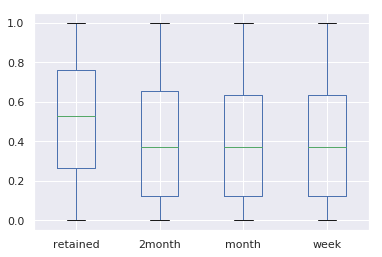

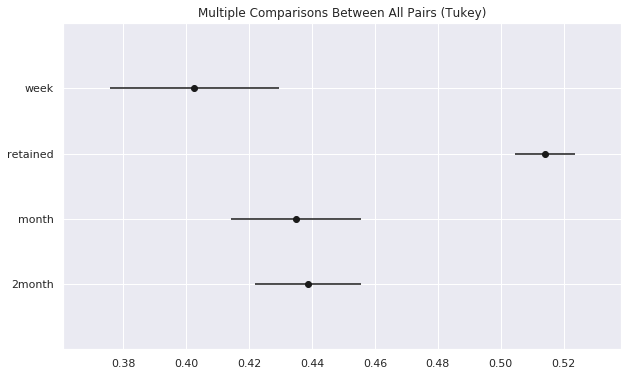

In [84]:
new_fe = train_activity.loc[train_activity.cnt_clear_inzone_skilled!=0, ['new_id','cnt_enter_inzone_skilled']].groupby(by='new_id').median()
eda = pd.merge(train_label,new_fe,left_on='new_id',right_on=new_fe.index)
new_variable_checker(eda,eda.cnt_enter_inzone_skilled);

In [33]:
sum(train_activity.cnt_enter_inzone_normal - train_activity.cnt_clear_inzone_normal < 0)

2091

In [49]:
train_activity.loc[train_activity.cnt_enter_inzone_normal - train_activity.cnt_clear_inzone_normal < 0,['new_id','cnt_enter_inzone_normal','cnt_clear_inzone_normal']]

,new_id,cnt_enter_inzone_normal,cnt_clear_inzone_normal
199,tr78427,23,26
906,tr98425,12,13
1384,tr776,33,34
1696,tr6932,70,71
1795,tr40422,33,34
2680,tr70482,17,18
3042,tr56069,64,65
3066,tr89052,10,11
4067,tr69482,43,44
4069,tr69482,26,27


In [61]:
pd.merge(train_label, train_activity.loc[train_activity.cnt_enter_inzone_normal - train_activity.cnt_clear_inzone_normal < 0,['new_id']]).drop_duplicates().label.value_counts()

retained    1338
month        154
week         152
2month       142
Name: label, dtype: int64

In [20]:
train_activity.loc[:,['new_id','wk','duel_cnt','duel_win']].loc[train_activity.new_id=='tr77084',:]

,new_id,wk,duel_cnt,duel_win
1432,tr77084,1,2,1
1433,tr77084,2,0,0
1434,tr77084,3,3,1
1435,tr77084,4,16,7
1436,tr77084,5,1,1
1437,tr77084,6,0,0
1438,tr77084,7,0,0
1439,tr77084,8,0,0


In [19]:
train_activity.loc[train_activity.duel_cnt!=0,['new_id','wk','duel_cnt','duel_win']]

,new_id,wk,duel_cnt,duel_win
42,tr93251,3,17,4
169,tr94096,2,1,1
527,tr39375,8,2,2
658,tr22771,3,11,5
844,tr45244,5,6,1
873,tr83205,2,13,6
875,tr83205,4,3,1
904,tr98425,1,1,1
910,tr98425,7,1,1
1063,tr7467,8,33,18
